This notebook contains our model analysis and results

What we need to do?

- Treat the variables before inputing in the model (for example put the difference in % terms instead of the absolute EPS, will only generate noise). Exclude variables like Moving Average that are in absolute terms and do everything percent-wise

- Abandon $R^{2}$ as a metric (Eric suggestion, I would discuss with Brownlees before) and build our own metric that give more valuability to the problem we are aiming to answer (for example, how much it deviates from the prediction in percentage terms and if the errors have the same direction - do they overestimate or underestimate movements in the stock price). Even with regression problem we can evaluate as a classification problem;
- Make the text features less "blackbox", try to measure which topic is positive and in the linear models see how they impact;

**Observations**

Use t1d (topic 1 directional), not t1g (guidance)

All this topics are based in the ones from S&P 500 research paper

In [21]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
#import talib #!pip install TA-lib | https://github.com/TA-Lib/ta-lib-python/issues/418

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import  GridSearchCV, HalvingGridSearchCV, train_test_split

In [10]:
# importing the data

df = pd.read_csv('../data/stock_prices_ec.csv')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [13]:
df.head()

,Unnamed: 0,Date,Adj Close,Volume,Ticker,eps_mean,eps_mean_report,sp_500_closeprice,content,10d_close_pct,10d_future_close,10d_future_close_pct,ma5,ma14,ma50,ma200,rsi5,rsi14,rsi50,rsi200,por_change_1_week_val,por_change_1_month_val,por_change_1_quater_val,por_change_1_year_val,ma_5days_1month,ma_10days_1quarter,ma_20days_1year,eps_mean_report_pdif,topic0,topic1,topic2,topic4,topic5,topic3,t1,t2,t3,t4,t5,t6,t1d,t2d,t3d,t4d,t5d,t6d,t1dg,t2dg,t3dg,t4dg,t5dg,t6dg,eps_surpise
0,0,2013-04-26,30.519445,10096800.0,ABBV,3.11429,2.83000,158.240005,Operator: Good morning and thank you for stand...,0.081387,29.747131,-0.005113,29.792409,28.830729,26.425866,NaN,82.857145,71.758046,69.768228,NaN,8.138732,13.448375,NaN,NaN,15.991188,NaN,NaN,-9.128565,0.085569,0.109772,0.467060,0.055661,0.281877,0.00000,0.088020,0.024450,0.007335,0.0,0.002445,0.000000,0.012225,0.002445,0.000000,0.0,0.0,0.0,0.034230,0.002445,0.000000,0.0,0.000000,0.0,-0.091286
1,1,2013-07-26,30.094526,4491100.0,ABBV,3.12750,2.69500,169.110001,Operator: Good morning and thank you for stand...,0.006065,30.450632,0.002355,29.825764,29.681081,29.219185,NaN,54.607623,60.242032,48.360002,NaN,0.606487,4.803558,2.754639,NaN,5.784629,1.133854,NaN,-13.828937,0.022762,0.075925,0.587229,0.059803,0.229713,0.02457,0.095355,0.022005,0.014670,0.0,0.000000,0.000000,0.014670,0.002445,0.004890,0.0,0.0,0.0,0.036675,0.002445,0.004890,0.0,0.000000,0.0,-0.138289
2,2,2013-10-25,33.423153,6956800.0,ABBV,3.13423,2.57500,175.949997,Operator: Good morning and thank you for stand...,0.020070,33.192654,-0.001383,32.936386,31.899823,30.546254,NaN,65.594850,69.194802,62.209311,NaN,2.007011,12.213035,9.931589,NaN,9.212339,11.294156,NaN,-17.842660,0.097875,0.083999,0.566253,0.038037,0.213788,0.00000,0.083916,0.018648,0.011655,0.0,0.004662,0.004662,0.004662,0.004662,0.000000,0.0,0.0,0.0,0.020979,0.004662,0.002331,0.0,0.000000,0.0,-0.178427
3,3,2014-01-31,33.640068,12863500.0,ABBV,3.15143,2.98333,178.179993,"Operator: Good morning, and thank you for stan...",0.030132,33.407730,-0.001385,32.754478,33.507795,34.304198,31.235010,70.454574,42.573080,51.367162,53.582978,3.013166,-4.540313,1.763654,37.156452,-5.787309,1.526260,NaN,-5.334086,0.067380,0.023356,0.628893,0.043189,0.237125,0.00000,0.105405,0.029730,0.024324,0.0,0.005405,0.000000,0.010811,0.000000,0.005405,0.0,0.0,0.0,0.048649,0.005405,0.010811,0.0,0.002703,0.0,-0.053341
4,4,2014-04-25,33.879078,7289100.0,ABBV,3.13085,2.99275,186.289993,Operator: Good morning and thank you for stand...,0.012152,35.285534,0.008168,34.201734,33.576038,34.824788,32.772187,61.390025,40.003843,48.411116,53.097360,1.215240,-4.026735,4.137344,11.008172,-4.533099,1.485603,19.582403,-4.410943,0.052113,0.012447,0.570821,0.042669,0.320704,0.00000,0.083732,0.021531,0.023923,0.0,0.000000,0.000000,0.016746,0.004785,0.004785,0.0,0.0,0.0,0.038278,0.004785,0.004785,0.0,0.000000,0.0,-0.044109


In [32]:
df['Date'].unique()

array(['2014-04-25', '2014-07-25', '2014-10-31', '2015-01-30',
       '2015-04-23', '2015-07-24', '2015-10-30', '2016-04-29',
       '2016-10-28', '2017-01-27', '2017-04-27', '2017-07-28',
       '2017-10-27', '2018-01-26', '2018-04-26', '2018-07-27',
       '2018-11-02', '2019-01-25', '2019-07-26', '2019-11-01',
       '2020-02-07', '2020-05-01', '2020-07-31', '2020-10-30',
       '2021-02-03', '2021-04-30', '2021-07-30', '2022-02-02',
       '2006-02-06', '2006-04-20', '2006-07-20', '2006-10-26',
       '2007-02-07', '2007-07-27', '2007-11-01', '2012-07-26',
       '2013-01-31', '2013-04-26', '2013-08-01', '2013-11-01',
       '2014-02-06', '2014-04-24', '2014-08-01', '2015-04-24',
       '2015-07-30', '2015-11-05', '2016-02-08', '2016-11-10',
       '2017-02-03', '2017-04-28', '2017-07-27', '2017-11-09',
       '2018-02-05', '2018-11-08', '2019-02-15', '2019-04-26',
       '2019-07-25', '2019-10-24', '2020-02-14', '2020-04-29',
       '2020-07-30', '2021-02-11', '2021-11-12', '2022-

In [18]:
# creating the relative for the EPS

df['eps_surprise'] = (df['eps_mean_report'] / df['eps_mean']) - 1

In [35]:
# defining features

target = ['10d_future_close_pct']

identification = ['Date', 'Ticker']

surprise = ['eps_surprise']

technical_features = ['rsi5', 'rsi14', 'rsi50', 'rsi200', 'por_change_1_week_val', 'por_change_1_month_val', 'por_change_1_quater_val', 'por_change_1_year_val']

topic_features = ['t1', 't2', 't3', 't4', 't5', 't6' ] # how much of the topic is there on the document
topic_features_d = ['t1d', 't2d', 't3d', 't4d', 't5d', 't6d'] # how much of the topic is there on the document and in which direction (if it's positive or negative)
topic_features_dg = ['t1dg', 't2dg', 't3dg', 't4dg', 't5dg', 't6dg'] # topic_features_d + if they are talking in the short term or long term

### Linear Model

In [41]:
# train test split
df = df.dropna()


X = df[surprise + technical_features + topic_features] # model with technical features and surprise
y = df[target]


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2000) #splitting randomly, it's correct?

In [42]:
# Add a constant to the features
X_train1 = sm.add_constant(X_train)
X_test1 = sm.add_constant(X_test)

# Create the linear model and complete the least squares fit
model = sm.OLS(y_train, X_train1)
results = model.fit()  # fit the model
print(results.summary())

print(results.pvalues)


# Make predictions from our model for train and test sets
train_predictions = results.predict(X_train1)
test_predictions = results.predict(X_test1)

                             OLS Regression Results                             
Dep. Variable:     10d_future_close_pct   R-squared:                       0.075
Model:                              OLS   Adj. R-squared:                  0.033
Method:                   Least Squares   F-statistic:                     1.806
Date:                  Thu, 15 Jun 2023   Prob (F-statistic):             0.0326
Time:                          17:14:12   Log-Likelihood:                 1272.8
No. Observations:                   351   AIC:                            -2514.
Df Residuals:                       335   BIC:                            -2452.
Df Model:                            15                                         
Covariance Type:              nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const 

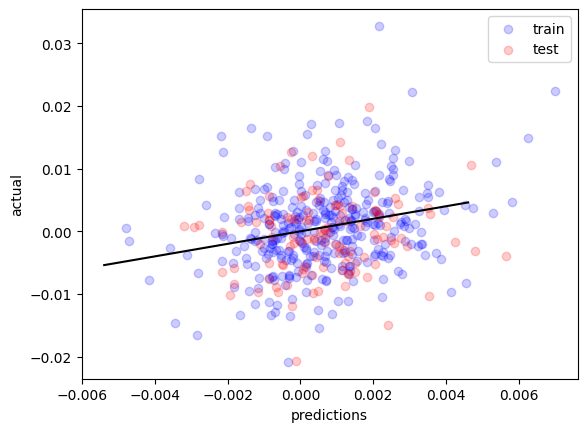

In [27]:
# Scatter the predictions vs the targets with 20% opacity
plt.scatter(train_predictions, y_train, alpha=0.2, color='b', label='train')
plt.scatter(test_predictions, y_test, alpha=0.2, color='r', label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k')

# Set the axis labels and show the plot
plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()  # show the legend
plt.show()

### Machine Learning methods

In [28]:
SEED = 2000
# models
models = [
          DecisionTreeRegressor(),
          RandomForestRegressor(),
          AdaBoostRegressor(),
         GradientBoostingRegressor()
         ]

# models parameters

dectree_params = {'max_features': range(4, 10),
                  'max_depth': range(3, 6),
                  'min_samples_leaf': range(5, 10),
                  'random_state': [SEED]}

randomforest_params = {'max_features': range(4, 10),
                  'n_estimators': [50, 100],
                  'max_depth': range(3, 6),
                  'min_samples_leaf': range(5, 10),
                  'random_state': [SEED]}

adab_params = {'learning_rate': [0.05, 1],
                  'n_estimators': [50, 100],
                  'loss':['linear', 'square'],
                  'random_state': [SEED]}

gb_params = {'learning_rate': [0.05, 1],
                  'n_estimators': [50, 100],
                  'max_depth': range(3, 6),
                'max_features': range(4, 10),
                  'random_state': [SEED]}

params = [ dectree_params, randomforest_params, adab_params, gb_params]
names = ['DecisionTree_Regressor', 'RandomForest_Regressor', 'AdaBoost_Regressor',
        'GradientBoosting_Regressor']
scores = {}

# gridsearch
for i, model in enumerate(models):
    print(f"Grid-Searching for model {names[i]}...")
    best_model = HalvingGridSearchCV(model, params[i], n_jobs=4, cv=5, 
                              scoring='neg_root_mean_squared_error', verbose = 0) #using RMSE as metric for scoring
    best_model.fit(X_train, y_train)
    print(f"Best model fitted")
    #assign the best parameters to my models
    models[i].set_params(**best_model.best_params_)

    print(f'{names[i]} chosen hyperparameters: {best_model.best_params_}')
    print(f'{names[i]} RMSE score on train sample: {-best_model.best_score_}')

Grid-Searching for model DecisionTree_Regressor...
Best model fitted
DecisionTree_Regressor chosen hyperparameters: {'max_depth': 3, 'max_features': 4, 'min_samples_leaf': 9, 'random_state': 2000}
DecisionTree_Regressor RMSE score on train sample: 0.007025405441820634
Grid-Searching for model RandomForest_Regressor...


/Users/lucascosta/opt/anaconda3/envs/deeplearningapp/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/lucascosta/opt/anaconda3/envs/deeplearningapp/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/lucascosta/opt/anaconda3/envs/deeplearningapp/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/lucascost

Best model fitted
RandomForest_Regressor chosen hyperparameters: {'max_depth': 5, 'max_features': 4, 'min_samples_leaf': 8, 'n_estimators': 50, 'random_state': 2000}
RandomForest_Regressor RMSE score on train sample: 0.006798631055703763
Grid-Searching for model AdaBoost_Regressor...


/Users/lucascosta/opt/anaconda3/envs/deeplearningapp/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lucascosta/opt/anaconda3/envs/deeplearningapp/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lucascosta/opt/anaconda3/envs/deeplearningapp/lib/python3.9/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lucascosta/opt/anaconda3/envs/deeplearningapp/lib/python3.9/site-packages/sklearn

Best model fitted
AdaBoost_Regressor chosen hyperparameters: {'learning_rate': 0.05, 'loss': 'linear', 'n_estimators': 50, 'random_state': 2000}
AdaBoost_Regressor RMSE score on train sample: 0.006729749744120285
Grid-Searching for model GradientBoosting_Regressor...


/Users/lucascosta/opt/anaconda3/envs/deeplearningapp/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lucascosta/opt/anaconda3/envs/deeplearningapp/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lucascosta/opt/anaconda3/envs/deeplearningapp/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lucascosta/opt/anaconda3/envs/deeplearningapp/lib/python3.9/site-packages/sklearn/ensemble/_gb.p

Best model fitted
GradientBoosting_Regressor chosen hyperparameters: {'learning_rate': 0.05, 'max_depth': 3, 'max_features': 6, 'n_estimators': 50, 'random_state': 2000}
GradientBoosting_Regressor RMSE score on train sample: 0.006775853679010671


/Users/lucascosta/opt/anaconda3/envs/deeplearningapp/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lucascosta/opt/anaconda3/envs/deeplearningapp/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lucascosta/opt/anaconda3/envs/deeplearningapp/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/lucascosta/opt/anaconda3/envs/deeplearningapp/lib/python3.9/site-packages/sklearn/ensemble/_gb.p

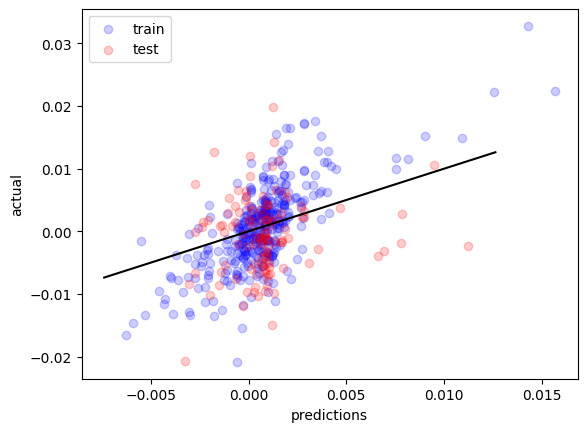

In [30]:
# getting the predictions for the best model
train_predictions = best_model.predict(X_train)
test_predictions = best_model.predict(X_test)

plt.scatter(train_predictions, y_train, alpha=0.2, color='b', label='train')
plt.scatter(test_predictions, y_test, alpha=0.2, color='r', label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k')

plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()  
plt.show()

## Predicting something different

In [34]:
# importing the price only dataset


df_prices = pd.read_csv('../data/stock_prices_yahoo.csv')

df_prices.head()

,Unnamed: 0,index,Date,Open,High,Low,Close,Adj Close,Volume,Ticker
0,0,0,2013-02-01,36.840000,37.200001,36.520000,37.180000,24.526785,9527500,ABBV
1,1,1,2013-02-04,36.639999,37.299999,36.549999,37.279999,24.592743,6348000,ABBV
2,2,2,2013-02-05,37.419998,37.730000,37.180000,37.200001,24.539970,7284400,ABBV
3,3,3,2013-02-06,36.959999,37.279999,36.860001,37.139999,24.500391,5738900,ABBV
4,4,4,2013-02-07,37.570000,37.570000,35.799999,36.419998,24.025429,9872500,ABBV


In [49]:
from statsmodels.tsa.stattools import adfuller

# in level
for empresa in df_prices['Ticker'].unique():
    variable = np.log(df_prices[df_prices['Ticker'] == empresa]['Adj Close'])
    result = adfuller(variable)
    test_statistic = result[0]
    p_value = result[1]
    print(f"P-value: {p_value}")

P-value: 0.7384669354190918
P-value: 0.9263241920154581
P-value: 0.7934615854655935
P-value: 0.9449656067695262
P-value: 0.9979093860919198
P-value: 0.934028746179786
P-value: 0.8905676084169873
P-value: 0.8938940922326453
P-value: 0.8589844894084203
P-value: 0.70177133624941


In [50]:
# 1st diff

for empresa in df_prices['Ticker'].unique():
    variable = np.log(df_prices[df_prices['Ticker'] == empresa]['Adj Close'])
    result = adfuller(variable.diff().dropna())
    test_statistic = result[0]
    p_value = result[1]
    print(f"P-value: {p_value}")

P-value: 2.669090471233519e-23
P-value: 0.0
P-value: 0.0
P-value: 2.9682104549115967e-30
P-value: 0.0
P-value: 5.7257412648525655e-24
P-value: 0.0
P-value: 0.0
P-value: 6.231331430999941e-30
P-value: 1.328076066554991e-29
